Question: If an autoencoder is trained on just the R channel, how well will that same model perform on G & B channels?

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize and extract color channels
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train_red, x_test_red = x_train[..., 0:1], x_test[..., 0:1]
x_train_green, x_test_green = x_train[..., 1:2], x_test[..., 1:2]
x_train_blue, x_test_blue = x_train[..., 2:3], x_test[..., 2:3]

# Autoencoder model for single-channel images
input_img = Input(shape=(32, 32, 1))
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = Conv2D(64, (3, 3), activation="relu", padding="same", strides=2)(x)
encoded = Conv2D(64, (3, 3), activation="relu", padding="same", strides=2)(x)

x = Conv2DTranspose(64, (3, 3), activation="relu", padding="same", strides=2)(encoded)
x = Conv2DTranspose(32, (3, 3), activation="relu", padding="same", strides=2)(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# Train on the red channel
history = autoencoder.fit(
    x_train_red,
    x_train_red,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_red, x_test_red),
)


# Function to evaluate and compare channels
def evaluate_on_channel(test_channel_data, title):
    reconstructed_imgs = autoencoder.predict(test_channel_data)
    mse = np.mean((test_channel_data - reconstructed_imgs) ** 2)
    ssim_score = np.mean(
        [
            ssim(test_channel_data[i].squeeze(), reconstructed_imgs[i].squeeze())
            for i in range(len(test_channel_data))
        ]
    )

    # Display a few examples
    n = 5
    fig, axes = plt.subplots(2, n, figsize=(15, 4))
    fig.suptitle(
        f"Evaluation on {title} Channel - MSE: {mse:.4f}, SSIM: {ssim_score:.4f}",
        fontsize=16,
    )
    for i in range(n):
        axes[0, i].imshow(test_channel_data[i].squeeze(), cmap="gray")
        axes[1, i].imshow(reconstructed_imgs[i].squeeze(), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    plt.show()

    return mse, ssim_score


# Evaluate on Red, Green, and Blue channels
results = {
    "Red Channel": evaluate_on_channel(x_test_red, "Red"),
    "Green Channel": evaluate_on_channel(x_test_green, "Green"),
    "Blue Channel": evaluate_on_channel(x_test_blue, "Blue"),
}

results

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - loss: 0.0189 - val_loss: 0.0016
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - loss: 0.0015 - val_loss: 8.2611e-04
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - loss: 8.7623e-04 - val_loss: 6.1427e-04
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - loss: 6.1514e-04 - val_loss: 5.7570e-04
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - loss: 4.9664e-04 - val_loss: 4.2059e-04
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - loss: 3.7176e-04 - val_loss: 2.7848e-04
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 127ms/step - loss: 2.8407e-04 - val_loss: 2.3181e-04
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 55s 140ms/step - loss: 2.7409e-04 - val_loss: 1.8104e-04
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 55s 141ms/step - loss: 2.1302e-04 - val_loss: 5.2122e-04
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 53s 136ms/step - loss: 2.2416e-04 - val_loss: 1.3571e-04
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


ValueError: Since image dtype is floating point, you must specify the data_range parameter. Please read the documentation carefully (including the note). It is recommended that you always specify the data_range anyway.

Without structural similarity

391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - loss: 0.0177 - val_loss: 0.0016
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
MSE on Red Channel: 0.0016


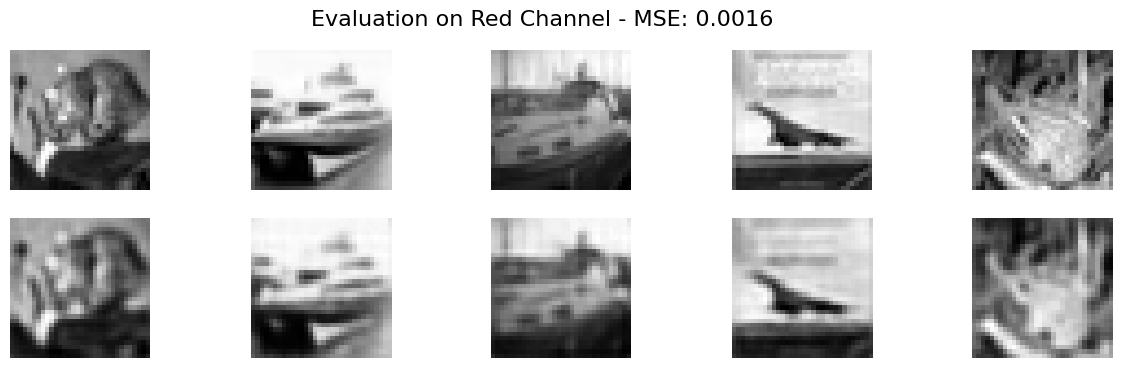

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
MSE on Green Channel: 0.0016


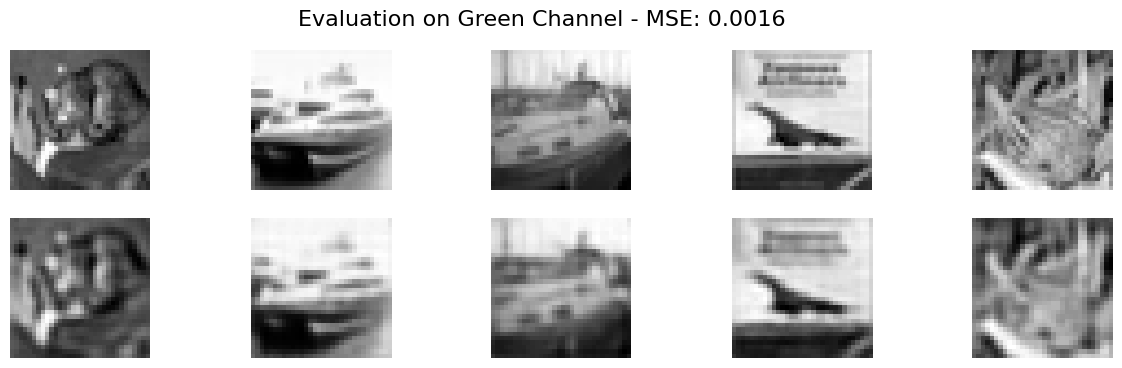

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
MSE on Blue Channel: 0.0016


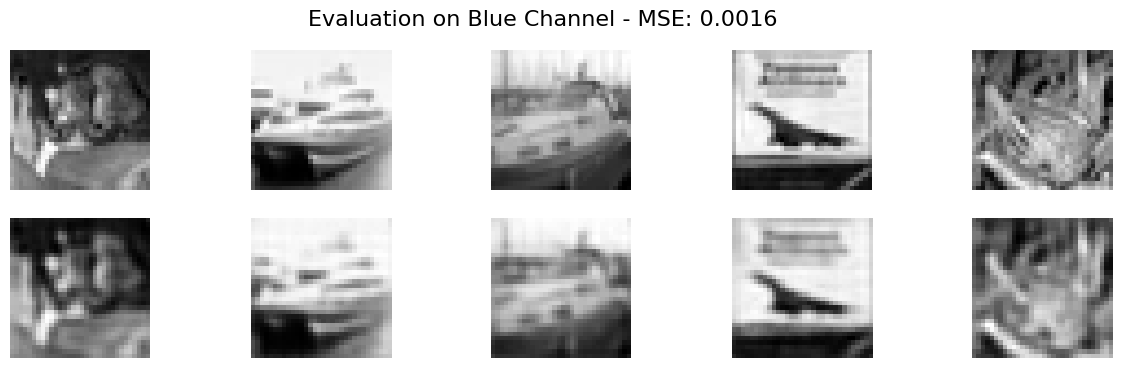

{'Red Channel': 0.0016099550942233903,
 'Green Channel': 0.0015765275562321759,
 'Blue Channel': 0.0015668693993205387}

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize and extract color channels
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train_red, x_test_red = x_train[..., 0:1], x_test[..., 0:1]
x_train_green, x_test_green = x_train[..., 1:2], x_test[..., 1:2]
x_train_blue, x_test_blue = x_train[..., 2:3], x_test[..., 2:3]

# Autoencoder model for single-channel images
input_img = Input(shape=(32, 32, 1))
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = Conv2D(64, (3, 3), activation="relu", padding="same", strides=2)(x)
encoded = Conv2D(64, (3, 3), activation="relu", padding="same", strides=2)(x)

x = Conv2DTranspose(64, (3, 3), activation="relu", padding="same", strides=2)(encoded)
x = Conv2DTranspose(32, (3, 3), activation="relu", padding="same", strides=2)(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# Train on the red channel
history = autoencoder.fit(
    x_train_red,
    x_train_red,
    epochs=1,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_red, x_test_red),
)


# Function to evaluate MSE on different channels
def evaluate_on_channel(test_channel_data, title):
    reconstructed_imgs = autoencoder.predict(test_channel_data)
    mse = np.mean((test_channel_data - reconstructed_imgs) ** 2)
    print(f"MSE on {title} Channel: {mse:.4f}")

    # Display a few examples
    n = 5
    fig, axes = plt.subplots(2, n, figsize=(15, 4))
    fig.suptitle(f"Evaluation on {title} Channel - MSE: {mse:.4f}", fontsize=16)
    for i in range(n):
        axes[0, i].imshow(test_channel_data[i].squeeze(), cmap="gray")
        axes[1, i].imshow(reconstructed_imgs[i].squeeze(), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    plt.show()

    return mse


# Evaluate on Red, Green, and Blue channels
results = {
    "Red Channel": evaluate_on_channel(x_test_red, "Red"),
    "Green Channel": evaluate_on_channel(x_test_green, "Green"),
    "Blue Channel": evaluate_on_channel(x_test_blue, "Blue"),
}

results